In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import subprocess, warnings
from Stats import *
from skopt import gp_minimize
from skopt.space import Real

In [ ]:
# set fibre parameters to be used in template file
length = 1000
Corediam = 8.2
Claddiam = 125
Core_sep = 60
taper_ratio = 10
core_num = 1
Core_delta = 0.01
background_index = 1.456
delta = 0.012

with open("fibre_prop.json", "w") as f:
        json.dump({"Length": length,
                   "Corediam": Corediam,
                   "Claddiam": Claddiam,
                   "Core_sep": Core_sep,
                   "taper_ratio": taper_ratio,
                   "core_num": core_num,
                   "core_num": core_num,
                   "Core_delta": Core_delta,
                   "background_index": background_index,
                   "delta": delta}, f)

# initialise prior space
'''
To do: ensure that choosing between normal and uniform priors is not needed. It is for MCMC but maybe not for gradient descent
'''
para_space = [
    Real(1.0, 40.0, name="core_diam")
]

In [ ]:
Iteration = 0
def RunRsoft(params, skip=False): 
    global Iteration

    Iteration += 1
    if isinstance(params, (list, tuple)):
        core_diam = params[0]
    else:
        core_diam = params
    # if Prior_type == "Uniform":
    #     # initialise uniform prior
    #     PriorName = Uniform(1.0,10.0,sample_no)

    # elif Prior_type == "Normal":
    #     # initialise normal prior
    #     PriorName = Normal(1.0,10.0,3,sample_no)

    with open("prior.json", "w") as f:
        json.dump({"core_diam" : core_diam}, f)
    print(f"[Iteration {Iteration}] core_diam = {core_diam:.2f}")
    ###########################################################################################
    '''
    The purpose of skipping the simulation is to test if the plotting works within the function.
    '''
    if not skip: 
        # this envokes the rsoft interpreter to run any rstool related feature
        subprocess.run(["rspython", "Master_controller.py"], check=True)
    elif skip:
        warnings.warn('Prior space will change, use plot only for validation purposes!')
    ###########################################################################################

    df = pd.read_csv('Throughput_results.csv')

    col_names = f"{core_diam:.2f}"
    if col_names not in df.columns:
        raise KeyError(f"Column '{col_names}' not present in CSV file.")
    
    average = df[col_names].mean()
    return -average

In [4]:
rsoft_result = gp_minimize(RunRsoft, 
                           para_space,
                           n_calls = 30,
                           n_initial_points= 5,
                           acq_func = "EI",
                           random_state=42
                           )

[Iteration 1] core_diam = 32.07
[Iteration 2] core_diam = 8.15
[Iteration 3] core_diam = 31.41
[Iteration 4] core_diam = 24.28
[Iteration 5] core_diam = 18.39
[Iteration 6] core_diam = 1.00
[Iteration 7] core_diam = 10.50
[Iteration 8] core_diam = 8.96
[Iteration 9] core_diam = 40.00
[Iteration 10] core_diam = 6.84
[Iteration 11] core_diam = 13.79
[Iteration 12] core_diam = 7.86
[Iteration 13] core_diam = 5.06
[Iteration 14] core_diam = 8.43
[Iteration 15] core_diam = 36.80
[Iteration 16] core_diam = 7.74
[Iteration 17] core_diam = 9.35
[Iteration 18] core_diam = 8.42
[Iteration 19] core_diam = 21.22
[Iteration 20] core_diam = 8.40
[Iteration 21] core_diam = 7.76
[Iteration 22] core_diam = 8.41
[Iteration 23] core_diam = 11.90
[Iteration 24] core_diam = 8.02
[Iteration 25] core_diam = 8.51
[Iteration 26] core_diam = 7.92
[Iteration 27] core_diam = 8.52
[Iteration 28] core_diam = 7.51
[Iteration 29] core_diam = 8.26
[Iteration 30] core_diam = 8.85


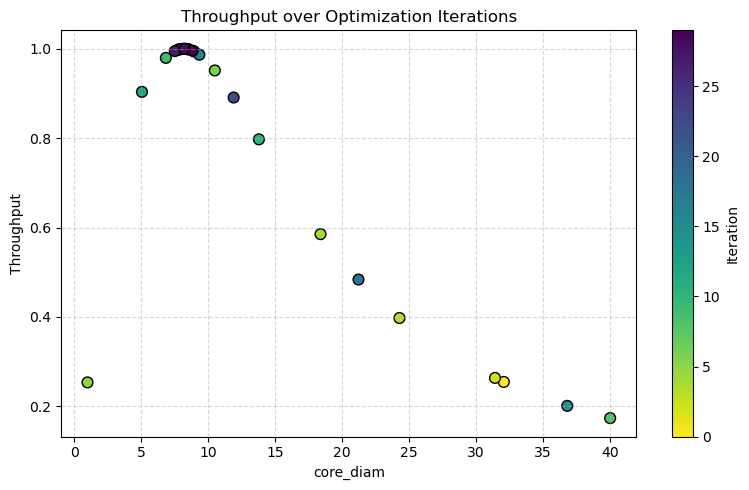

In [5]:
x_vals = [x[0] for x in rsoft_result.x_iters]
y_vals = [-val for val in rsoft_result.func_vals]
c_num = np.arange(len(x_vals))
plt.figure(figsize=(8, 5))
scatter = plt.scatter(x_vals, y_vals, c=c_num, cmap='viridis_r', s=60, edgecolor='k')
plt.colorbar(scatter, label="Iteration")
plt.xlabel("core_diam")
plt.ylabel("Throughput")
plt.title("Throughput over Optimization Iterations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
print(f"Best parameters:")
for name, val in zip("core_diam", rsoft_result.x):
    print(f"  {name}: {val:.3f}")

print(f"Max throughput: {-rsoft_result.fun:.4f}")


Best parameters:
  c: 8.154
Max throughput: 1.0000


<Axes: >

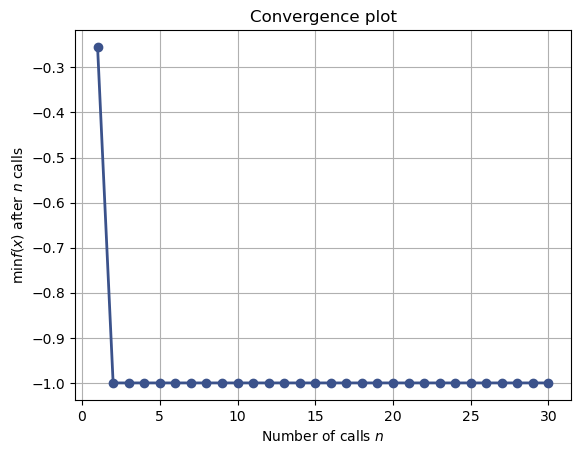

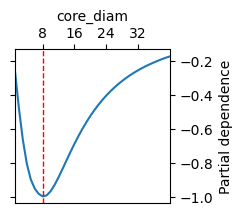

In [7]:
from skopt.plots import *
plot_convergence(rsoft_result)
plot_objective(rsoft_result)
# plot_evaluations(rsoft_result)
